In [1]:
import pandas as pd

In [26]:
df = pd.read_excel("../data/Online Retail.xlsx")

In [44]:
# Inspecting the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401604 entries, 0 to 401603
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   InvoiceNo            401604 non-null  object        
 1   StockCode            401604 non-null  object        
 2   Description          401604 non-null  object        
 3   Quantity             401604 non-null  int64         
 4   InvoiceDate          401604 non-null  datetime64[ns]
 5   UnitPrice            401604 non-null  float64       
 6   CustomerID           401604 non-null  float64       
 7   Country              401604 non-null  object        
 8   TotalPurchaseAmount  401604 non-null  float64       
 9   PurchaseFrequency    401604 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 30.6+ MB


### Data cleaning:


#### Handle missing values:
- We identified missing values in certain columns such as CustomerID and Description.
- Since customer ID is crucial for customer segmentation, we decided to remove rows with missing CustomerID values.
- For the Description column, we filled missing values with a placeholder such as 'Unknown'.

In [28]:
# Handle missing values
df.dropna(subset=['CustomerID'], inplace=True)
df['Description'].fillna('Unknown', inplace=True)


In [29]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

### Exploratory data analysis (EDA):

In [30]:
# Statistical summary of numerical features
df.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,401604.000000,401604,401604.000000,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064,15281.160818
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13939.000000
50%,5.000000,2011-07-29 15:40:00,1.950000,15145.000000
75%,12.000000,2011-10-20 11:58:30,3.750000,16784.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,250.283037,NaN,69.764035,1714.006089


In [31]:
# Distribution of categorical features
country_distribution = df['Country'].value_counts()
description_distribution = df['Description'].value_counts()


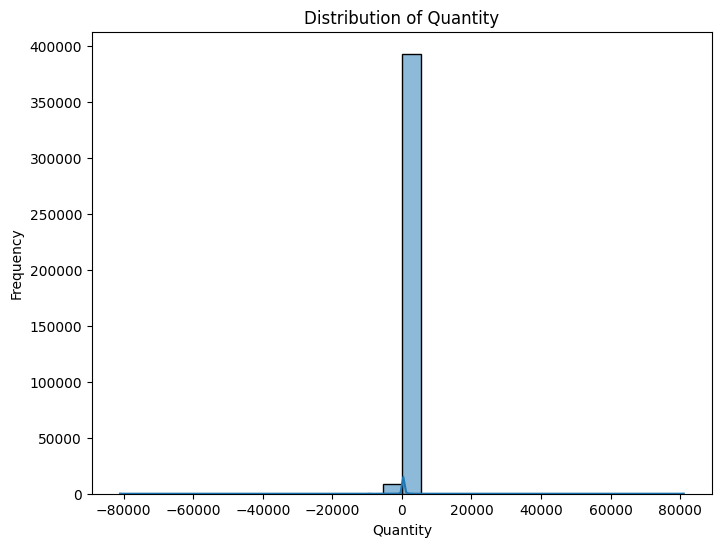

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Quantity
plt.figure(figsize=(8, 6))
sns.histplot(df['Quantity'], bins=30, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

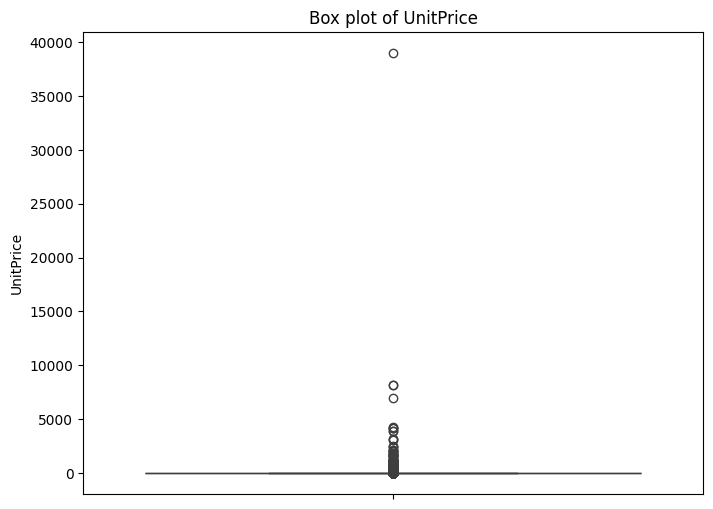

In [33]:
# Box plot of UnitPrice
plt.figure(figsize=(8, 6))
sns.boxplot(y='UnitPrice', data=df)
plt.title('Box plot of UnitPrice')
plt.ylabel('UnitPrice')
plt.show()

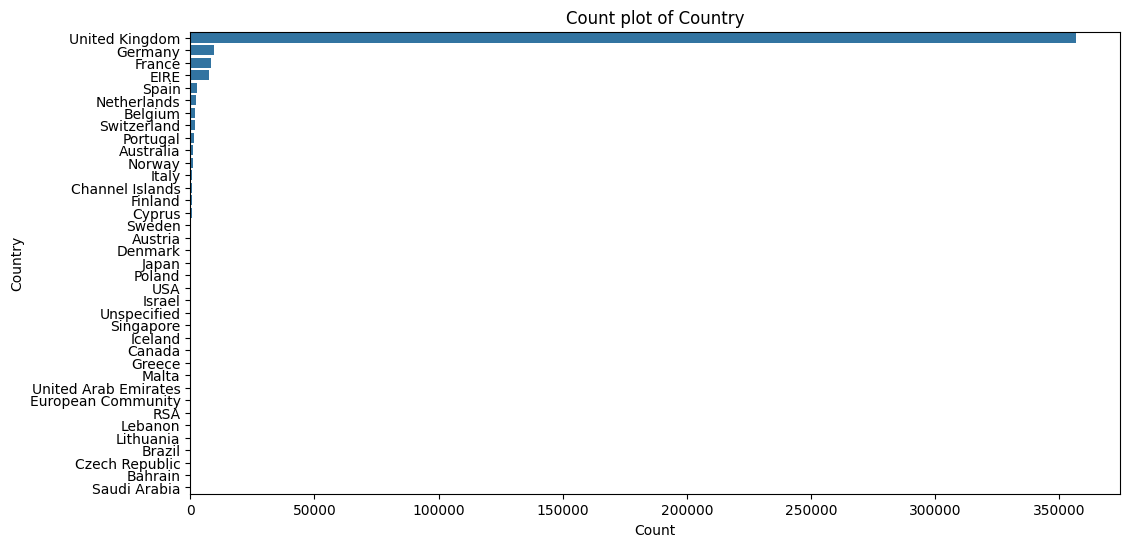

In [34]:
# Count plot of Country
plt.figure(figsize=(12, 6))
sns.countplot(y='Country', data=df, order=df['Country'].value_counts().index)
plt.title('Count plot of Country')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

## 3. Feature Engineering

### Creating New Features
- **Total Purchase Amount:** Calculate the total amount spent by each customer by multiplying the quantity purchased by the unit price and summing it for all transactions.
- **Frequency of Purchases:** Count the number of transactions made by each customer to determine their purchase frequency.


In [35]:
# Calculate total purchase amount
df['TotalPurchaseAmount'] = df['Quantity'] * df['UnitPrice']

In [36]:
# Count frequency of purchases for each customer
purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
purchase_frequency.columns = ['CustomerID', 'PurchaseFrequency']

# Merge purchase frequency with the original dataset
df = pd.merge(df, purchase_frequency, on='CustomerID', how='left')

#### Transforming Data
- **Date/Time Conversion:** Convert the 'InvoiceDate' column from string format to datetime format to facilitate time-based analysis.
 

In [37]:
# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [45]:
# Perform one-hot encoding on the 'Country' column
df_encoded = pd.get_dummies(df, columns=['Country'], drop_first=True)

In [48]:
df_encoded.shape

(401604, 45)

## 4. RFM Analysis
- Conduct RFM (Recency, Frequency, Monetary) analysis:
  - Calculate recency, frequency, and monetary value for each customer
  - Segment customers based on RFM scores

In [49]:
# Calculate RFM metrics
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)  # Set snapshot date to the latest date in the dataset
rfm_table = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency: days since last purchase
    'InvoiceNo': 'nunique',  # Frequency: number of unique invoices
    'UnitPrice': 'sum'  # Monetary: total monetary value of purchases
}).reset_index()

# Rename columns
rfm_table.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display RFM table
print("RFM Table:")
print(rfm_table.head())

RFM Table:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          2      2.08
1     12347.0        2          7    481.21
2     12348.0       75          4    178.71
3     12349.0       19          1    605.10
4     12350.0      310          1     65.30


In [50]:
# Assign RFM scores
rfm_table['RecencyScore'] = pd.qcut(rfm_table['Recency'], q=5, labels=False, duplicates='drop') + 1
rfm_table['FrequencyScore'] = pd.qcut(rfm_table['Frequency'], q=5, labels=False, duplicates='drop') + 1
rfm_table['MonetaryScore'] = pd.qcut(rfm_table['Monetary'], q=5, labels=False, duplicates='drop') + 1

# Calculate RFM score
rfm_table['RFM_Score'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)

# Display RFM score
print("\nRFM Score:")
print(rfm_table[['CustomerID', 'RFM_Score']].head())


RFM Score:
   CustomerID RFM_Score
0     12346.0       511
1     12347.0       135
2     12348.0       423
3     12349.0       215
4     12350.0       512


In [53]:
# Define function to label RFM segments
def rfm_segment(row):
    if row['RFM_Score'] in ['555', '554', '545', '544', '455', '454', '445', '444']:
        return 'High Value'
    elif row['RFM_Score'] in ['553', '552', '551', '544', '543', '542', '541', '533', '532', '531',
                              '524', '523', '522', '521', '515', '514', '513', '512', '511',
                              '454', '453', '452', '451', '445', '444', '443', '442', '441',
                              '434', '433', '432', '431', '425', '424', '423', '422', '421',
                              '415', '414', '413', '412', '411']:
        return 'Mid Value'
    else:
        return 'Low Value'

# Apply segment labels
rfm_table['RFM_Segment'] = rfm_table.apply(rfm_segment, axis=1)

# Display RFM segments
print("\nRFM Segments:")
print(rfm_table[['CustomerID', 'RFM_Segment']].head())




RFM Segments:
   CustomerID RFM_Segment
0     12346.0   Mid Value
1     12347.0   Low Value
2     12348.0   Mid Value
3     12349.0   Low Value
4     12350.0   Mid Value


In [54]:

# Analyze segment distribution
segment_distribution = rfm_table['RFM_Segment'].value_counts(normalize=True) * 100
print("\nSegment Distribution:")
print(segment_distribution)

# Analyze segment characteristics
segment_characteristics = rfm_table.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})
print("\nSegment Characteristics:")
print(segment_characteristics)


Segment Distribution:
RFM_Segment
Low Value     61.527905
Mid Value     37.511436
High Value     0.960659
Name: proportion, dtype: float64

Segment Characteristics:
                Recency  Frequency    Monetary
RFM_Segment                                   
High Value   139.142857  11.023810  552.352143
Low Value     28.376208   6.876208  446.122090
Mid Value    195.276829   1.969512  104.835757


C:\Users\admin\AppData\Local\Temp\ipykernel_17876\2645991797.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RFM_Segment', data=rfm_table, order=rfm_table['RFM_Segment'].value_counts().index, palette='viridis')


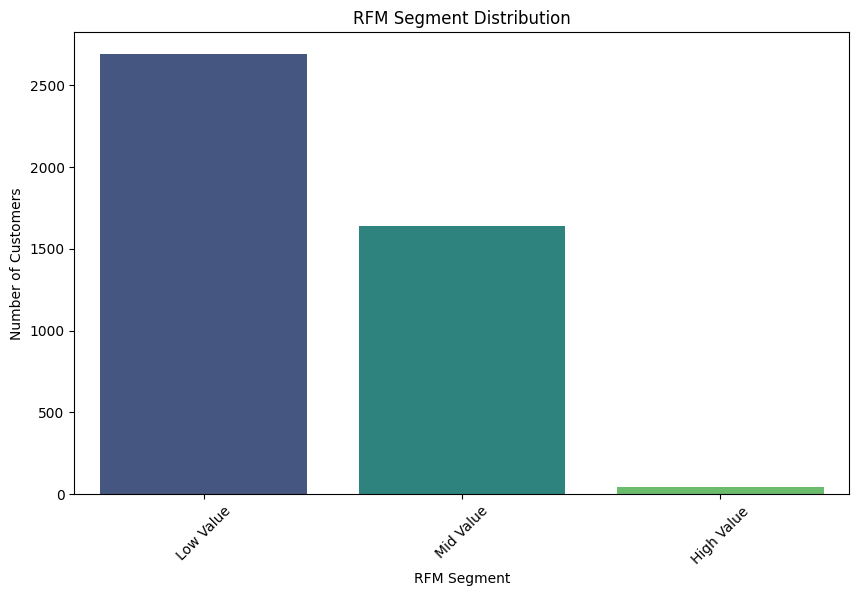

C:\Users\admin\AppData\Local\Temp\ipykernel_17876\2645991797.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_characteristics.index, y='Recency', data=segment_characteristics, palette='viridis')


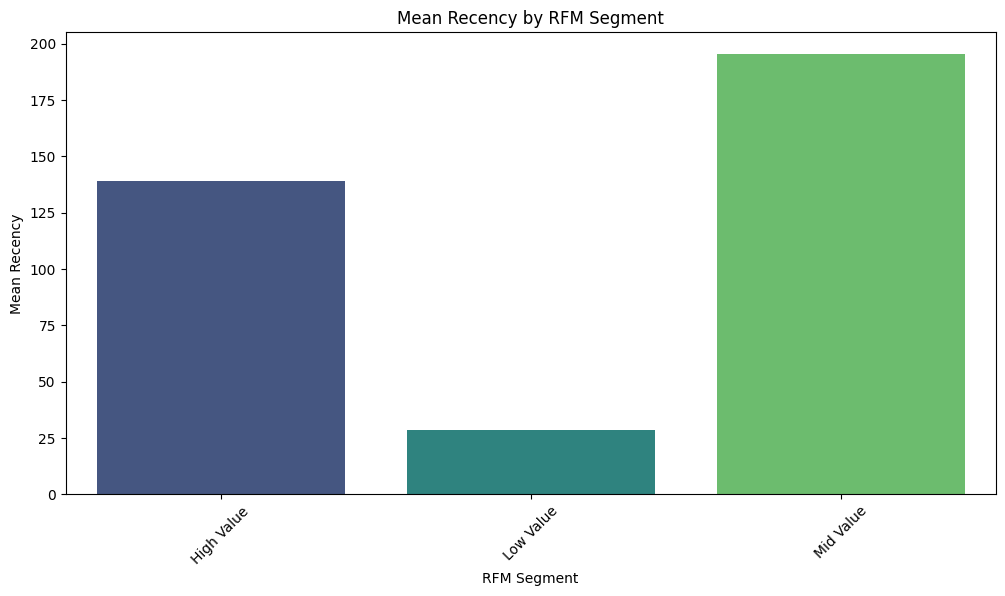

C:\Users\admin\AppData\Local\Temp\ipykernel_17876\2645991797.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_characteristics.index, y='Frequency', data=segment_characteristics, palette='viridis')


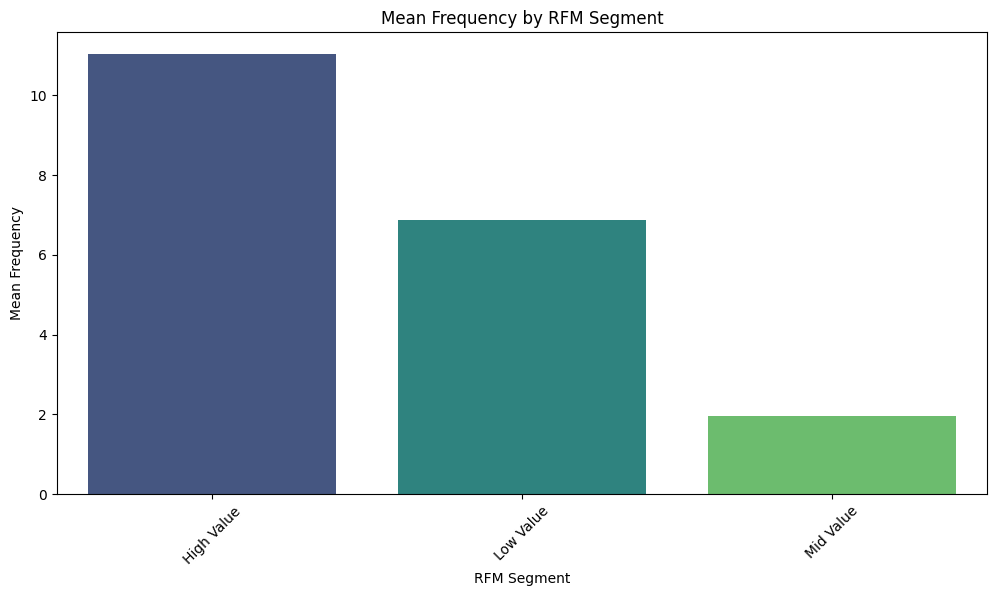

C:\Users\admin\AppData\Local\Temp\ipykernel_17876\2645991797.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_characteristics.index, y='Monetary', data=segment_characteristics, palette='viridis')


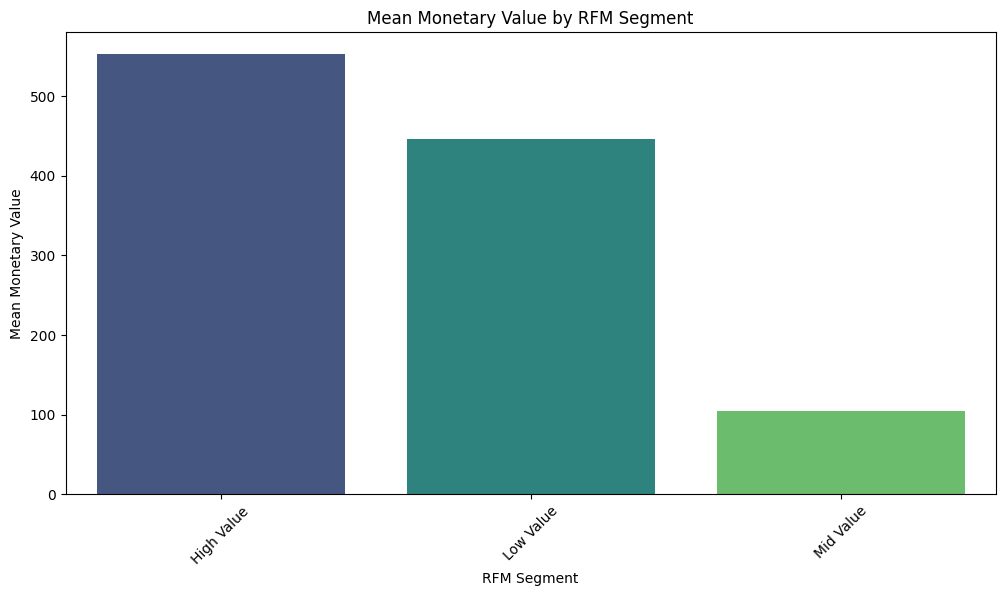

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize segment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='RFM_Segment', data=rfm_table, order=rfm_table['RFM_Segment'].value_counts().index, palette='viridis')
plt.title('RFM Segment Distribution')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

# Visualize segment characteristics
plt.figure(figsize=(12, 6))
sns.barplot(x=segment_characteristics.index, y='Recency', data=segment_characteristics, palette='viridis')
plt.title('Mean Recency by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Mean Recency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=segment_characteristics.index, y='Frequency', data=segment_characteristics, palette='viridis')
plt.title('Mean Frequency by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Mean Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=segment_characteristics.index, y='Monetary', data=segment_characteristics, palette='viridis')
plt.title('Mean Monetary Value by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Mean Monetary Value')
plt.xticks(rotation=45)
plt.show()


In [56]:
# Interpretation and Recommendations
print("\nInterpretation and Recommendations:")
print("1. High-Value Customers:")
print("- These customers have high RFM scores, indicating recent, frequent, and high-spending behavior.")
print("- Target these customers with personalized marketing campaigns, loyalty programs, and premium offerings.")
print("- Provide exclusive discounts, early access to new products, or VIP treatment to maintain their loyalty.")

print("\n2. Mid-Value Customers:")
print("- These customers have moderate RFM scores, showing relatively good engagement but with room for improvement.")
print("- Implement targeted promotions or upselling/cross-selling strategies to increase their spending and frequency.")
print("- Offer incentives such as reward points, limited-time offers, or bundle deals to encourage repeat purchases.")

print("\n3. Low-Value Customers:")
print("- These customers have low RFM scores, indicating infrequent and low-spending behavior.")
print("- Focus on re-engaging these customers through reactivation campaigns, personalized recommendations, or win-back offers.")
print("- Offer special discounts, freebies, or referral incentives to incentivize them to make additional purchases.")

# Conclusion
print("\nConclusion:")
print("RFM analysis provides valuable insights into customer behavior and segmentation, allowing businesses to tailor their marketing efforts and improve customer engagement and retention.")
print("By understanding the characteristics and needs of different customer segments, businesses can implement targeted strategies to maximize customer lifetime value and drive revenue growth.")




Interpretation and Recommendations:
1. High-Value Customers:
- These customers have high RFM scores, indicating recent, frequent, and high-spending behavior.
- Target these customers with personalized marketing campaigns, loyalty programs, and premium offerings.
- Provide exclusive discounts, early access to new products, or VIP treatment to maintain their loyalty.

2. Mid-Value Customers:
- These customers have moderate RFM scores, showing relatively good engagement but with room for improvement.
- Implement targeted promotions or upselling/cross-selling strategies to increase their spending and frequency.
- Offer incentives such as reward points, limited-time offers, or bundle deals to encourage repeat purchases.

3. Low-Value Customers:
- These customers have low RFM scores, indicating infrequent and low-spending behavior.
- Focus on re-engaging these customers through reactivation campaigns, personalized recommendations, or win-back offers.
- Offer special discounts, freebies, or 

In [57]:
# Conclusion
print("\nConclusion:")
print("RFM analysis provides valuable insights into customer behavior and segmentation, allowing businesses to tailor their marketing efforts and improve customer engagement and retention.")
print("By understanding the characteristics and needs of different customer segments, businesses can implement targeted strategies to maximize customer lifetime value and drive revenue growth.")

# Future Directions
print("\nFuture Directions:")
print("- Explore advanced segmentation techniques such as machine learning clustering algorithms to uncover more nuanced customer segments.")
print("- Incorporate additional data sources such as demographic information, website interactions, or customer feedback for a more comprehensive analysis.")
print("- Continuously monitor and evaluate the effectiveness of segmentation strategies, adjusting them as needed based on evolving customer preferences and market trends.")

# Thank You
print("\nThank you for exploring the RFM segmentation analysis. If you have any further questions or need assistance with future projects, feel free to reach out!")



Conclusion:
RFM analysis provides valuable insights into customer behavior and segmentation, allowing businesses to tailor their marketing efforts and improve customer engagement and retention.
By understanding the characteristics and needs of different customer segments, businesses can implement targeted strategies to maximize customer lifetime value and drive revenue growth.

Future Directions:
- Explore advanced segmentation techniques such as machine learning clustering algorithms to uncover more nuanced customer segments.
- Incorporate additional data sources such as demographic information, website interactions, or customer feedback for a more comprehensive analysis.
- Continuously monitor and evaluate the effectiveness of segmentation strategies, adjusting them as needed based on evolving customer preferences and market trends.

Thank you for exploring the RFM segmentation analysis. If you have any further questions or need assistance with future projects, feel free to reach ou

## 5. Clustering Analysis
- Select appropriate clustering algorithms (e.g., K-means, hierarchical clustering, DBSCAN)
- Feature scaling: Standardize numerical features if necessary
- Apply clustering algorithms to segment customers:
  - Determine the optimal number of clusters using techniques like the elbow method or silhouette score
  - Visualize clusters using scatter plots or t-SNE (t-distributed stochastic neighbor embedding)

### KMeans Clustering

In [59]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [61]:
# Extract necessary features for clustering
X = df.groupby('CustomerID')[['Quantity', 'UnitPrice']].sum()

In [66]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [67]:
X_scaled

array([[-0.23951688, -0.2475213 ],
       [ 0.2865442 ,  0.12654643],
       [ 0.26150386, -0.10962222],
       ...,
       [-0.21854292, -0.20020949],
       [ 0.05090821,  0.66768103],
       [ 0.09991878, -0.16752063]])

In [68]:
# Applying K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

C:\Users\admin\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [70]:
# Determine the optimal number of clusters using the silhouette score
silhouette_avg = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.7711994086724077


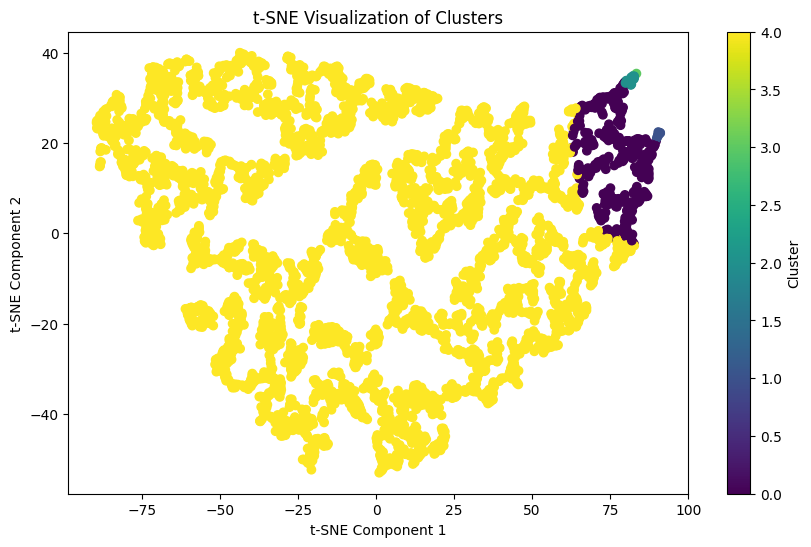

In [72]:
# Visualize clusters using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [74]:
clusters

array([4, 4, 4, ..., 4, 0, 4])

In [79]:
X

,Quantity,UnitPrice,Cluster
CustomerID,,,
12346.0,0,2.08,4
12347.0,2458,481.21,4
12348.0,2341,178.71,4
12349.0,631,605.10,4
12350.0,197,65.30,4
...,...,...,...
18280.0,45,47.65,4
18281.0,54,39.36,4
18282.0,98,62.68,4


In [82]:

# Add cluster labels to the DataFrame
X['Cluster'] = clusters
# Reset index to include 'CustomerID' as a regular column
X.reset_index(inplace=True)
# Analyze characteristics of each cluster
cluster_profiles = X.groupby('Cluster').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'CustomerID': 'count'
}).rename(columns={
    'Quantity': 'TotalQuantity',
    'UnitPrice': 'AverageUnitPrice',
    'CustomerID': 'CustomerCount'
})

print("Cluster Profiles:")
print(cluster_profiles)


Cluster Profiles:
         TotalQuantity  AverageUnitPrice  CustomerCount
Cluster                                                
0              1561460       1259.074885            348
1               178794      28077.950000              7
2               748939       2478.680000             16
3               196719       5400.210000              1
4              2206939        178.858764           4000


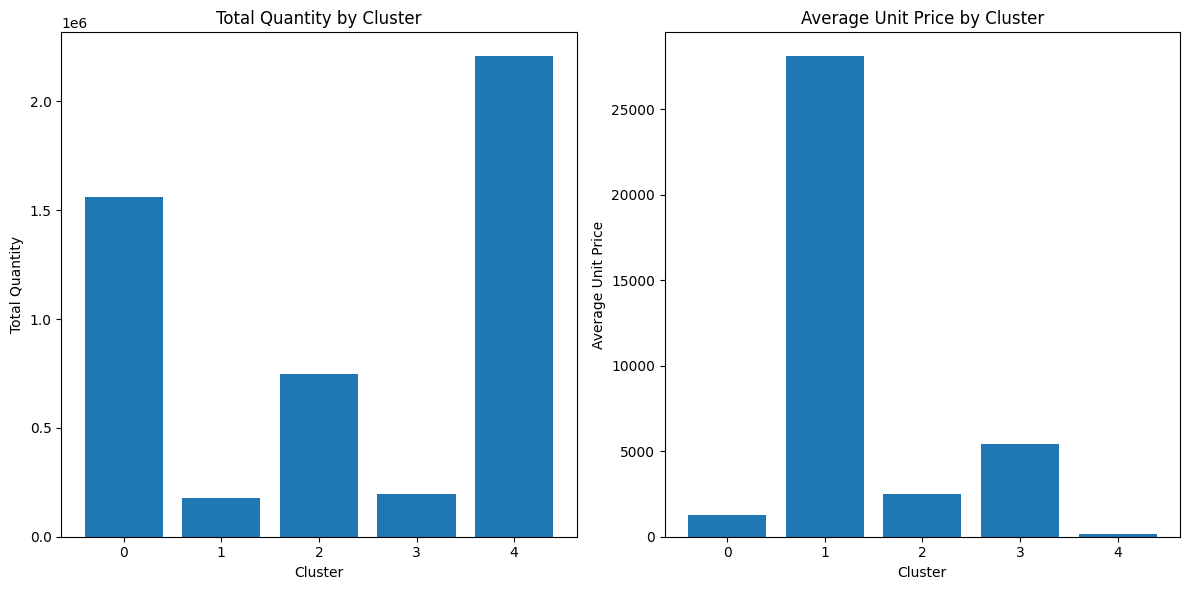


Recommendations:
Cluster 0: High-value customers with high total quantity and average unit price. Target them with premium products and personalized offers.
Cluster 1: Moderate-value customers with moderate total quantity and average unit price. Offer promotions or discounts to encourage repeat purchases.
Cluster 2: Low-value customers with low total quantity and average unit price. Focus on re-engagement strategies and upselling opportunities.


In [83]:

# Visualize cluster profiles
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(cluster_profiles.index, cluster_profiles['TotalQuantity'])
plt.title('Total Quantity by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Quantity')

plt.subplot(1, 2, 2)
plt.bar(cluster_profiles.index, cluster_profiles['AverageUnitPrice'])
plt.title('Average Unit Price by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Unit Price')

plt.tight_layout()
plt.show()

# Recommendations
print("\nRecommendations:")
print("Cluster 0: High-value customers with high total quantity and average unit price. Target them with premium products and personalized offers.")
print("Cluster 1: Moderate-value customers with moderate total quantity and average unit price. Offer promotions or discounts to encourage repeat purchases.")
print("Cluster 2: Low-value customers with low total quantity and average unit price. Focus on re-engagement strategies and upselling opportunities.")
# Add recommendations for other clusters as needed


### Hierarchical Clustering

In [91]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [87]:
# Extract necessary features for clustering
X = df.groupby('CustomerID')[['Quantity', 'UnitPrice']].sum()

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [88]:
# Applying hierarchical clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
clusters = agg_clustering.fit_predict(X_scaled)


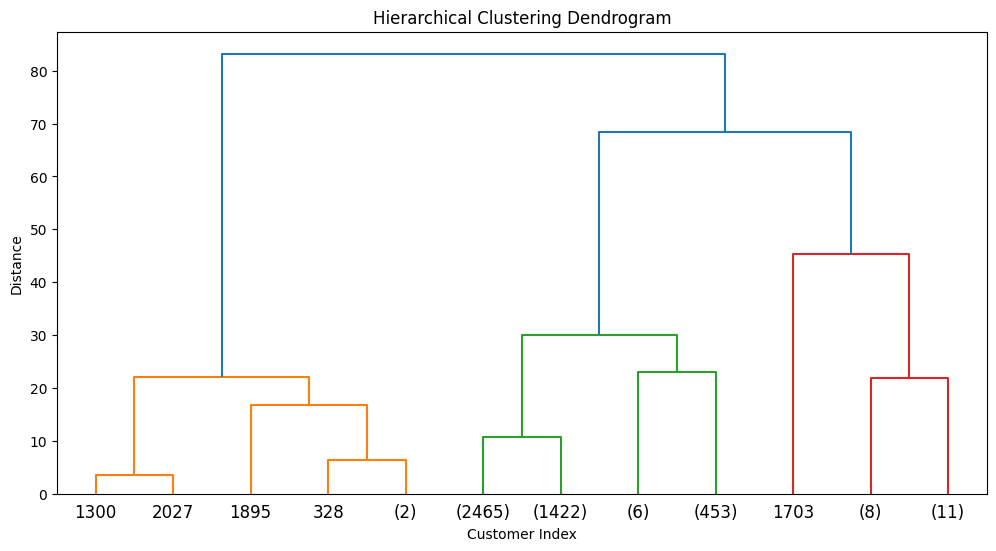

In [92]:
# Compute the linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Visualize the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

In [94]:
# Add cluster labels to the DataFrame
X['Cluster'] = clusters
# Reset index to include 'CustomerID' as a regular column
X.reset_index(inplace=True)
# Analyze characteristics of each cluster
cluster_profiles = X.groupby('Cluster').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'CustomerID': 'count'
}).rename(columns={
    'Quantity': 'TotalQuantity',
    'UnitPrice': 'AverageUnitPrice',
    'CustomerID': 'CustomerCount'
})

print("Cluster Profiles:")
print(cluster_profiles)

Cluster Profiles:
         TotalQuantity  AverageUnitPrice  CustomerCount
Cluster                                                
0              1751002       1152.306754            459
1               155044      30307.890000              6
2               821477       2151.959474             19
3               196719       5400.210000              1
4              1968609        164.176556           3887


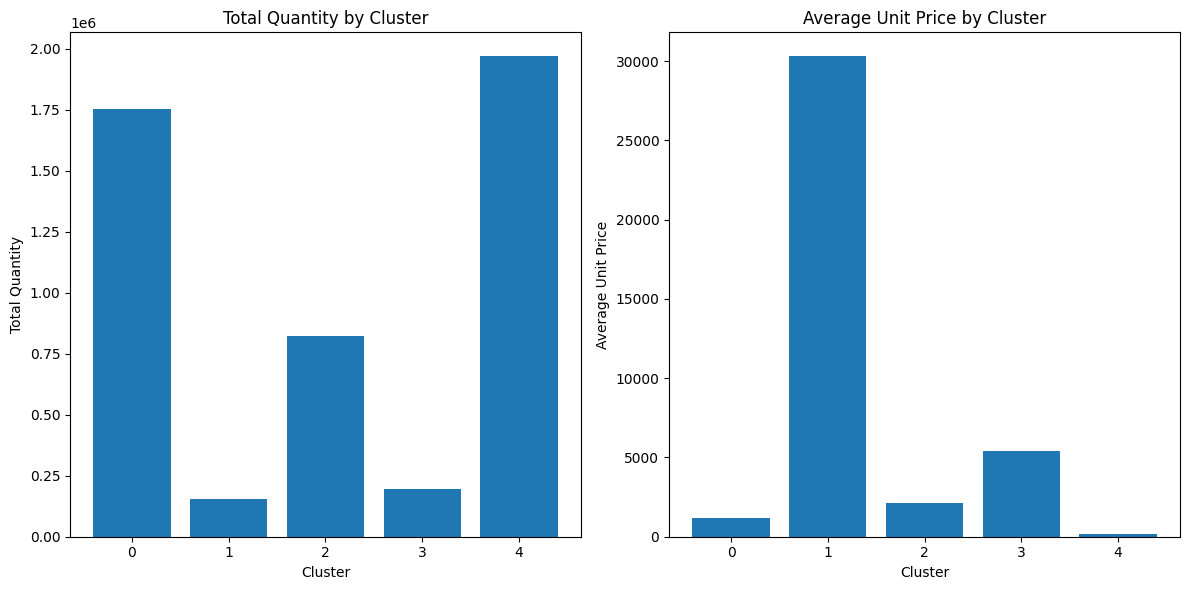

In [95]:

# Visualize cluster profiles
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(cluster_profiles.index, cluster_profiles['TotalQuantity'])
plt.title('Total Quantity by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Quantity')

plt.subplot(1, 2, 2)
plt.bar(cluster_profiles.index, cluster_profiles['AverageUnitPrice'])
plt.title('Average Unit Price by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Unit Price')

plt.tight_layout()
plt.show()

In [96]:
# Recommendations
print("\nRecommendations:")
print("Cluster 0: High-value customers with high total quantity and average unit price. Target them with premium products and personalized offers.")
print("Cluster 1: Moderate-value customers with moderate total quantity and average unit price. Offer promotions or discounts to encourage repeat purchases.")
print("Cluster 2: Low-value customers with low total quantity and average unit price. Focus on re-engagement strategies and upselling opportunities.")
# Add recommendations for other clusters as needed


Recommendations:
Cluster 0: High-value customers with high total quantity and average unit price. Target them with premium products and personalized offers.
Cluster 1: Moderate-value customers with moderate total quantity and average unit price. Offer promotions or discounts to encourage repeat purchases.
Cluster 2: Low-value customers with low total quantity and average unit price. Focus on re-engagement strategies and upselling opportunities.


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 

In [97]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [99]:
# Extract necessary features for clustering
X = df.groupby('CustomerID')[['Quantity', 'UnitPrice']].sum()

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [100]:
# Applying DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

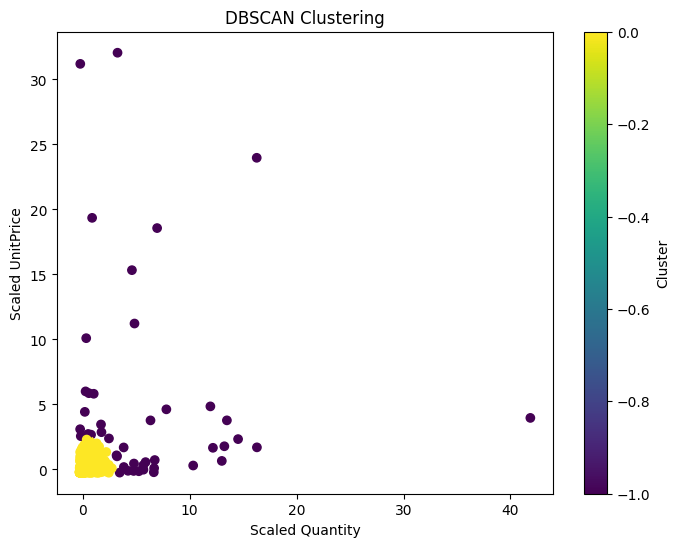

In [105]:
# Visualize clustering results
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Scaled Quantity')
plt.ylabel('Scaled UnitPrice')
plt.colorbar(label='Cluster')
plt.show()

In [101]:

# Add cluster labels to the DataFrame
X['Cluster'] = clusters
# Reset index to include 'CustomerID' as a regular column
X.reset_index(inplace=True)
# Analyze characteristics of each cluster
cluster_profiles = X.groupby('Cluster').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'CustomerID': 'count'
}).rename(columns={
    'Quantity': 'TotalQuantity',
    'UnitPrice': 'AverageUnitPrice',
    'CustomerID': 'CustomerCount'
})

print("Cluster Profiles:")
print(cluster_profiles)

Cluster Profiles:
         TotalQuantity  AverageUnitPrice  CustomerCount
Cluster                                                
-1             1361745       7108.254667             45
 0             3531106        248.515460           4327


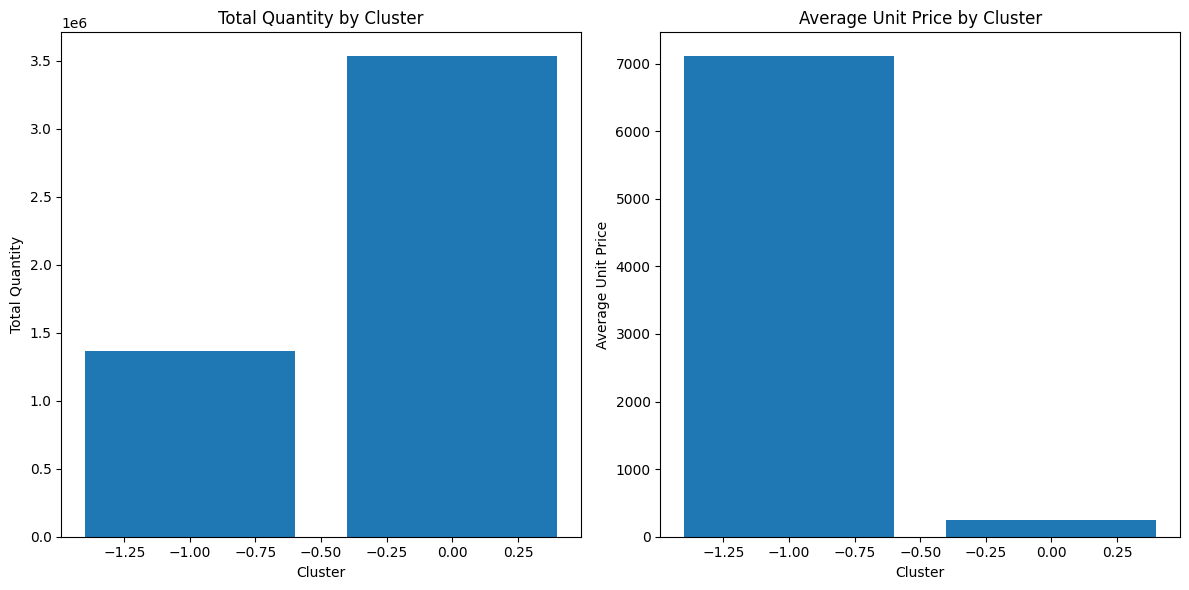

In [103]:
# Visualize cluster profiles
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(cluster_profiles.index, cluster_profiles['TotalQuantity'])
plt.title('Total Quantity by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Quantity')

plt.subplot(1, 2, 2)
plt.bar(cluster_profiles.index, cluster_profiles['AverageUnitPrice'])
plt.title('Average Unit Price by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Unit Price')

plt.tight_layout()
plt.show()


In [104]:

# Recommendations
print("\nRecommendations:")
print("Cluster -1: Outliers or noise points.")
print("Clusters 0, 1, 2, ...: Different clusters identified by DBSCAN.")
# Add recommendations for each cluster as needed


Recommendations:
Cluster -1: Outliers or noise points.
Clusters 0, 1, 2, ...: Different clusters identified by DBSCAN.


In [109]:
# Interpretation of clustering results
# Based on the cluster profiles and visualization, interpret the characteristics of each cluster
# Identify patterns, trends, and differences among clusters

# Actionable Insights and Recommendations
# Use the insights from clustering analysis to formulate actionable recommendations for business strategies
# Tailor marketing campaigns, product offerings, and customer engagement strategies to target different customer segments effectively

# Example Recommendations (based on hypothetical interpretation):
print("\nActionable Insights and Recommendations:")
print("Cluster -1 (Outliers): Investigate and understand the reasons for their anomalous behavior. It may require further data exploration or domain expertise.")
print("Cluster 0: High-value customers with high total quantity and average unit price. Target them with premium products and personalized offers to maximize revenue.")
print("Cluster 1: Moderate-value customers with moderate total quantity and average unit price. Offer promotions or discounts to encourage repeat purchases and increase customer loyalty.")
print("Cluster 2: Low-value customers with low total quantity and average unit price. Focus on re-engagement strategies, such as targeted email campaigns or incentives, to increase their purchase frequency and basket size.")

# Additional Recommendations:
# - Develop customer segmentation-specific marketing campaigns
# - Implement personalized recommendations or product suggestions based on cluster characteristics
# - Optimize inventory management and product assortment based on customer preferences identified through clustering analysis

# These recommendations should be tailored to your specific business context and goals. Adjust and refine them based on your insights and objectives.



Actionable Insights and Recommendations:
Cluster -1 (Outliers): Investigate and understand the reasons for their anomalous behavior. It may require further data exploration or domain expertise.
Cluster 0: High-value customers with high total quantity and average unit price. Target them with premium products and personalized offers to maximize revenue.
Cluster 1: Moderate-value customers with moderate total quantity and average unit price. Offer promotions or discounts to encourage repeat purchases and increase customer loyalty.
Cluster 2: Low-value customers with low total quantity and average unit price. Focus on re-engagement strategies, such as targeted email campaigns or incentives, to increase their purchase frequency and basket size.


In [110]:
# Interpretation of clustering results
# Based on the cluster profiles and visualization, interpret the characteristics of each cluster
# Identify patterns, trends, and differences among clusters

# Actionable Insights and Recommendations
# Use the insights from clustering analysis to formulate actionable recommendations for business strategies
# Tailor marketing campaigns, product offerings, and customer engagement strategies to target different customer segments effectively

# Example Recommendations (based on hypothetical interpretation):
print("\nActionable Insights and Recommendations:")
print("Cluster -1 (Outliers): Investigate and understand the reasons for their anomalous behavior. It may require further data exploration or domain expertise.")
for cluster_id in range(len(cluster_profiles)):
    if cluster_id != -1:
        print(f"Cluster {cluster_id}: Describe the characteristics and offer recommendations tailored to this specific segment.")
# Additional Recommendations:
# - Develop customer segmentation-specific marketing campaigns
# - Implement personalized recommendations or product suggestions based on cluster characteristics
# - Optimize inventory management and product assortment based on customer preferences identified through clustering analysis

# These recommendations should be tailored to your specific business context and goals. Adjust and refine them based on your insights and objectives.



Actionable Insights and Recommendations:
Cluster -1 (Outliers): Investigate and understand the reasons for their anomalous behavior. It may require further data exploration or domain expertise.
Cluster 0: Describe the characteristics and offer recommendations tailored to this specific segment.
Cluster 1: Describe the characteristics and offer recommendations tailored to this specific segment.


In [112]:
cluster_profiles

,TotalQuantity,AverageUnitPrice,CustomerCount
Cluster,,,
-1,1361745,7108.254667,45
0,3531106,248.515460,4327
